**Choose the data type**

1.   **iclus**       => 230 video from **full dataset**;
2.   **clinic-eval** => 58 video from a **clinical evaluation**

In [1]:
mode = "iclus" # @param ["iclus", "clinic-eval"]

# **Python Imports, GDrive mount and Settings**

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Python imports
import sys
import os
import h5py
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, Subset, DataLoader
from collections import defaultdict, Counter
from tqdm import tqdm

import torch
import torchvision
import torchvision.transforms as transforms

import importlib

In [4]:
# Definitions
rseed = 21                              # random seed number used in the splitting strategy

# Paths
base_path = '/content/drive/MyDrive/Tesi/dataset'
mode_path = base_path + '/' + mode + '/segmentation'

dataset_h5_path       = mode_path + '/dataset.h5'
pkl_frame_idxmap_path = mode_path + '/hdf5_frame_index_map.pkl'
pkl_hospitaldict_path = mode_path + '/hospitals-patients-dict.pkl'


In [5]:
# Remove the "/lollo" path if it exists
if base_path + "/lollo" in sys.path:
    sys.path.remove(base_path + "/lollo")

# Add the "/lollo" path
sys.path.append(base_path + "/lollo")

import augmentlib
importlib.reload(augmentlib)

import viewlib
importlib.reload(viewlib)

<module 'viewlib' from '/content/drive/MyDrive/Tesi/dataset/lollo/viewlib.py'>

# **Custom Class PreHDF5Dataset**

Class for the HDF5 dataset that *returns metadata for each frame-score pair* (e.g. patient and medical center atm).

In [6]:
class PreHDF5Dataset(Dataset):
    def __init__(self, file_path):
        self.file_path = file_path
        self.pkl_file_path = pkl_frame_idxmap_path
        self.h5file = h5py.File(file_path, 'r')
        self.group_names = list(self.h5file.keys())
        self.total_videos, self.total_frames, self.frame_index_map = self.elaborate_frameidx_map()

    def load_cached_data(self):
        if os.path.exists(self.pkl_file_path):
            with open(self.pkl_file_path, 'rb') as pickle_file:
                return pickle.load(pickle_file)
        else:
            return None

    def save_cached_data(self, data):
        with open(self.pkl_file_path, 'wb') as pickle_file:
            pickle.dump(data, pickle_file)

    def elaborate_frameidx_map(self):
        # Try to load cached data
        cached_data = self.load_cached_data()
        if cached_data is not None:
            total_videos, total_frames, frame_index_map = cached_data
            print(f"{total_videos} videos ({total_frames} frames) loaded from cached data.")
        else:
            total_videos = 0
            max_frame_idx_end = 0
            frame_index_map = {}

            # Create tqdm progress bar
            with tqdm(desc="Elaborating frames and index mapping", unit=' video', dynamic_ncols=True) as pbar:
                for group_name in self.group_names:
                    for video_name in self.h5file[group_name]:
                        video_group = self.h5file[group_name][video_name]
                        frame_idx_start = video_group.attrs['frame_idx_start']
                        frame_idx_end = video_group.attrs['frame_idx_end']
                        max_frame_idx_end = max(max_frame_idx_end, frame_idx_end)
                        for i in range(frame_idx_start, frame_idx_end + 1):
                            frame_index_map[i] = (group_name, video_name)
                        total_videos += 1
                        pbar.update(1)

            total_frames = max_frame_idx_end + 1

            # Save data to pickle file for future use
            self.save_cached_data((total_videos, total_frames, frame_index_map))
            print(f"\n{total_videos} videos ({total_frames} frames) loaded and cached.")

        return total_videos, total_frames, frame_index_map

    def __len__(self):
        return self.total_frames

    def __getitem__(self, index):
        if index < 0 or index >= self.total_frames:
            raise IndexError("Index out of range")

        group_name, video_name = self.frame_index_map[index]
        video_group = self.h5file[group_name][video_name]
        frame_data  = video_group['frames'][f'frame_{index}'][:]
        mask_data   = video_group['masks'][f'mask_{index}'][:]
        target_data = video_group['targets'][f'target_{index}']

        # get metadata
        patient = video_group.attrs['patient']
        medical_center = video_group.attrs['medical_center']

        return index, frame_data, mask_data, target_data, patient, medical_center

In [7]:
# Create the custom dataset
dataset = PreHDF5Dataset(dataset_h5_path)

Elaborating frames and index mapping: 230 video [00:10, 21.20 video/s]


230 videos (2154 frames) loaded and cached.


# **Splitting Strategy**

In [8]:
def splitting_strategy(dataset, train_ratio=0.7, pkl_file=pkl_hospitaldict_path):
    # iteration seed
    random.seed(rseed)

    # Check if the pickle file exists
    if os.path.exists(pkl_file):
        # If the pickle file exists, load the data from it
        with open(pkl_file, 'rb') as f:
            data = pickle.load(f)
            medical_center_patients = data['medical_center_patients']
            data_index = data['data_index']
            score_counts = data['score_counts']
    else:
        # If the pickle file doesn't exist, create the data
        medical_center_patients = defaultdict(set)
        data_index = {}
        score_counts = defaultdict(int)

        for index, (_, _, _, target_data, patient, medical_center) in enumerate(tqdm(dataset)):
            medical_center_patients[medical_center].add(patient)
            data_index[index] = (patient, medical_center)
            score_counts[int(target_data[()])] += 1

        # Save the data to a pickle file
        data = {
            'medical_center_patients': medical_center_patients,
            'data_index': data_index,
            'score_counts': score_counts
        }

        with open(pkl_file, 'wb') as f:
            pickle.dump(data, f)

    # Split the patients for each medical center
    train_indices = []
    test_indices = []

    # Lists to store statistics about medical centers and patients
    train_patients_by_center = defaultdict(set)
    test_patients_by_center = defaultdict(set)
    frame_counts_by_center = defaultdict(int)
    frame_counts_by_center_patient = defaultdict(lambda: defaultdict(int))

    for medical_center, patients in medical_center_patients.items():
        patients = list(patients)
        random.shuffle(patients)
        split_index = int(train_ratio * len(patients))

        for index, (patient, center) in data_index.items():
            if center == medical_center:
                if patient in patients[:split_index]:
                    train_indices.append(index)
                    train_patients_by_center[medical_center].add(patient)
                else:
                    test_indices.append(index)
                    test_patients_by_center[medical_center].add(patient)

                frame_counts_by_center[medical_center] += 1
                frame_counts_by_center_patient[medical_center][patient] += 1

    # Create training and test subsets
    train_dataset_subset = Subset(dataset, train_indices)
    test_dataset_subset = Subset(dataset, test_indices)

    # Sum up statistics info
    split_info = {
        'medical_center_patients': medical_center_patients,
        'frame_counts_by_center': frame_counts_by_center,
        'train_patients_by_center': train_patients_by_center,
        'test_patients_by_center': test_patients_by_center,
        'frame_counts_by_center_patient': frame_counts_by_center_patient,
        'total_train_frames': len(train_indices),
        'total_test_frames': len(test_indices),
        'score_counts': score_counts
    }

    return train_dataset_subset, test_dataset_subset, split_info

In [9]:
train_subset, test_subset, split_info = splitting_strategy(dataset, 0.7)

100%|██████████| 2154/2154 [01:27<00:00, 24.63it/s]


In [10]:
# Print diagnostic information
score_counts = split_info['score_counts']
total_train_frames = split_info['total_train_frames']
total_test_frames = split_info['total_test_frames']
fcount_by_medcenter_patient = split_info['frame_counts_by_center_patient']
fcount_by_medcenter = split_info['frame_counts_by_center']
medcenter_patients = split_info['medical_center_patients']
trainp_by_medcenter = split_info['train_patients_by_center']
testp_by_medcenter = split_info['test_patients_by_center']

# extract the number of unique patients
total_patients = len([p for p_set in medcenter_patients.values() for p in p_set])

print(f"~~~~~ Dataset Information ~~~~~")
print(f"Patients: {total_patients}")
print(f"Scores distribution:")
for score in sorted(score_counts.keys()):
    print(f"  Score {score}: {score_counts[score]} frames")

print(f"\n~~~~~~ Train/Test Split  ~~~~~~")

print(f"Train set: {total_train_frames} frames ({round(total_train_frames*100/len(dataset))}%)")
print(f"Test set: {total_test_frames} frames ({round(total_test_frames*100/len(dataset))}%)")

for medical_center in medcenter_patients.keys():
    print(f"\n\t----")
    print(f"Medical Center: {medical_center}")
    print(f">>Total: {fcount_by_medcenter[medical_center]} frames")
    print(f">>Train: {sum(fcount_by_medcenter_patient[medical_center][patient] for patient in trainp_by_medcenter[medical_center])} frames")
    for patient in trainp_by_medcenter[medical_center]:
        print(f"   {patient}:\t{fcount_by_medcenter_patient[medical_center][patient]} frames")
    print(f">>Test: {sum(fcount_by_medcenter_patient[medical_center][patient] for patient in testp_by_medcenter[medical_center])} frames")
    for patient in testp_by_medcenter[medical_center]:
        print(f"   {patient}:\t{fcount_by_medcenter_patient[medical_center][patient]} frames")
    print(f"\t----")

~~~~~ Dataset Information ~~~~~
Patients: 33
Scores distribution:
  Score 0: 701 frames
  Score 1: 425 frames
  Score 2: 769 frames
  Score 3: 259 frames

~~~~~~ Train/Test Split  ~~~~~~
Train set: 1173 frames (54%)
Test set: 981 frames (46%)

	----
Medical Center: Brescia
>>Total: 1410 frames
>>Train: 834 frames
   Paziente 9:	155 frames
   Paziente 10:	153 frames
   Paziente 1:	9 frames
   Paziente 12:	84 frames
   Paziente 5:	60 frames
   Paziente 13:	81 frames
   Paziente 11:	98 frames
   Paziente 2:	78 frames
   Paziente 4:	116 frames
>>Test: 576 frames
   Paziente 7:	136 frames
   Paziente 8:	129 frames
   Paziente 6:	200 frames
   Paziente 3:	111 frames
	----

	----
Medical Center: Gemelli - Roma
>>Total: 158 frames
>>Train: 42 frames
   Paziente 2:	39 frames
   Paziente 3:	3 frames
>>Test: 116 frames
   Paziente 1:	116 frames
	----

	----
Medical Center: Lucca
>>Total: 118 frames
>>Train: 51 frames
   Paziente 1:	51 frames
>>Test: 67 frames
   Paziente 2:	67 frames
	----

	----

# **Custom Class HDF5Dataset and PyTorch DataLoader**
Custom replica class of `PreHDF5Dataset` to train the neural network (only return the pair `[frame, score]`)

In [11]:
alpha_wrapping  = 90.0
cropping_size   = 190
blur_kernel     = random.randint(1, 10) * 2 + 1 # Size of the blur kernel (5x5 in the case of a Gaussian filter)
rotation_degree = 23  # Maximum rotation angle of ±23°
contrast_factor = random.uniform(0.5, 1.5)

aug = transforms.Compose([
                                augmentlib.ElasticWarpping(alpha_wrapping),
                                augmentlib.Cropping(cropping_size),
                                augmentlib.Blur(blur_kernel),
                                augmentlib.RandomRotation(rotation_degree),
                                augmentlib.AdjustContrast(contrast_factor)
                            ])


In [12]:
class HDF5Dataset(Dataset):
    def __init__(self, hdf5_dataset, augmentation=False):
        self.hdf5_dataset = hdf5_dataset
        self.augmentation = augmentation
        self.resize_size = (224, 224)

    def __len__(self):
        return len(self.hdf5_dataset)

    def __getitem__(self, index):
        _, frame_data, mask_data, target_data, _, _ = self.hdf5_dataset[index]

        #TODO:
        #img, mask = norm_data(frame_data,mask_data)

        # Convert the frame data into a tensor
        frame_tensor = transforms.ToTensor()(frame_data)
        mask_tensor  = transforms.ToTensor()(mask_data)

        # Apply resize transformation (mandatory for both train and test sets)
        frame_tensor = transforms.functional.resize(frame_tensor, self.resize_size, antialias=True)
        mask_tensor  = transforms.functional.resize(mask_tensor, self.resize_size, antialias=True)

        # Apply custom transformation if enabled (train set)
        if self.augmentation:
            frame_tensor, mask_tensor = self.augmentation([frame_tensor, mask_tensor])

        # Apply resize transformation (mandatory for both train and test sets)
        frame_tensor = transforms.functional.resize(frame_tensor, self.resize_size, antialias=True)
        mask_tensor  = transforms.functional.resize(mask_tensor, self.resize_size, antialias=True)

        # Move channels to the last dimension (needed after transformations)
        frame_tensor = frame_tensor.permute(1, 2, 0) # Move channels to the last dimension (needed after resize)
        mask_tensor  = mask_tensor.permute(1, 2, 0) # Move channels to the last dimension (needed after resize)


        # Convert the target data into score
        score = int(target_data[()])
        return frame_tensor, mask_tensor, score


In [13]:
# Batch size
batch_size = 4

# Create the Datasets
train_dataset = HDF5Dataset(train_subset, aug)
test_dataset = HDF5Dataset(test_subset)

# Create the DataLoaders
# it's generally recommended to turn shuffling off for val/test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

# **Test Batch Printing**

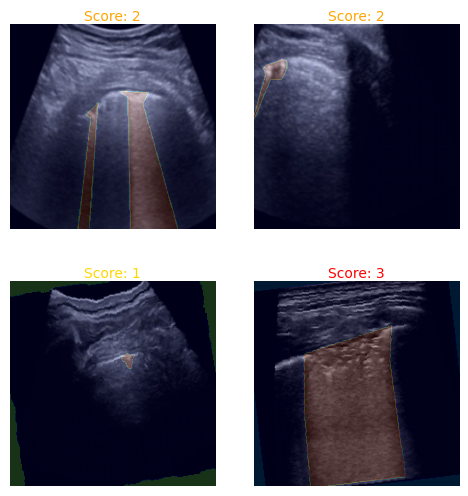

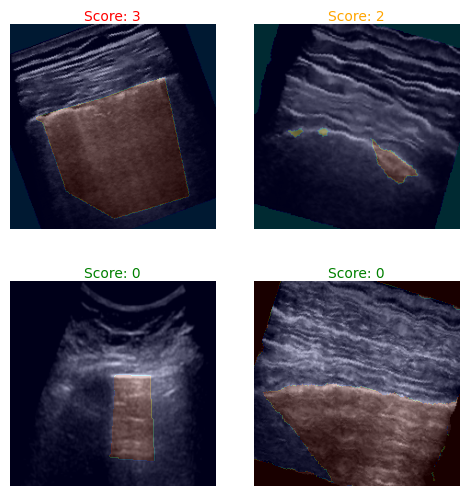

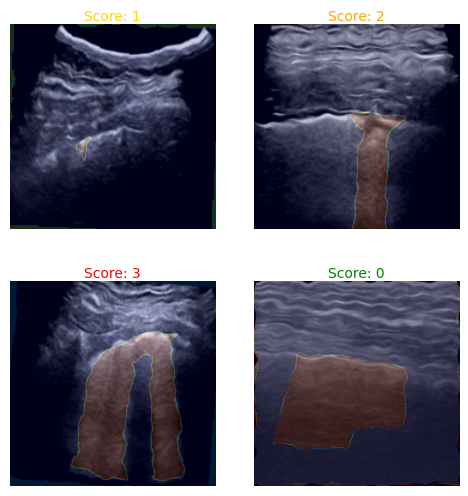

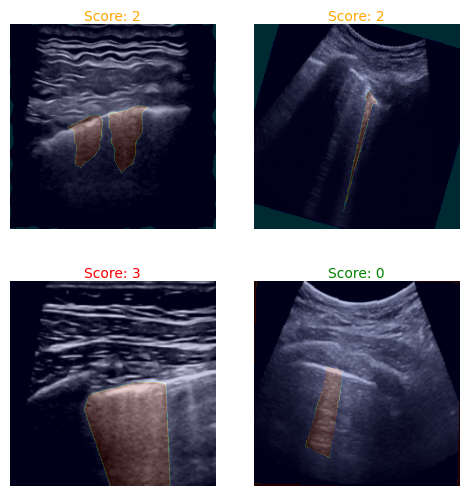

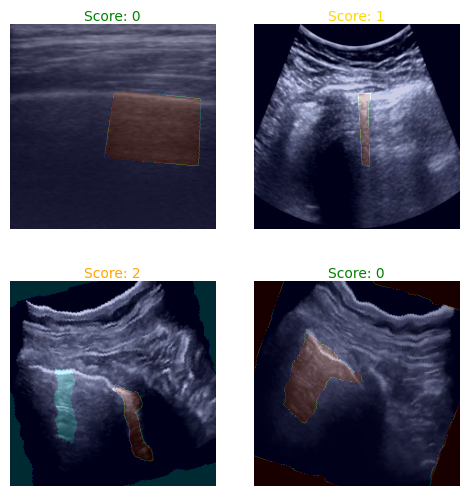



Media: [0.17632177 0.17995298 0.18413016]
Deviazione Standard: [0.19301845 0.19623657 0.20188677]


In [14]:
# train set dataloader (iteration test)
viewlib.dataloader_display_iterator(train_dataloader)

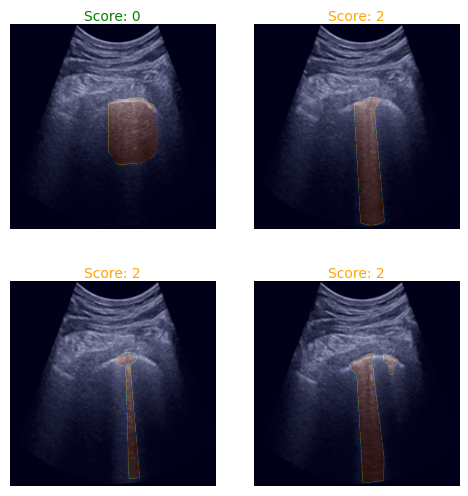

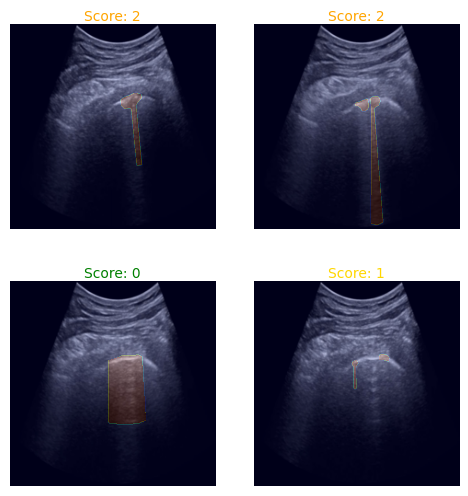

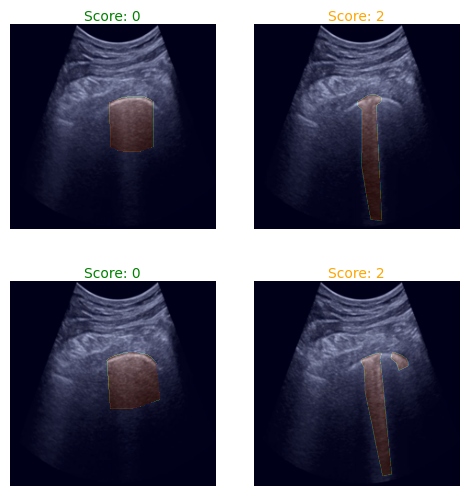

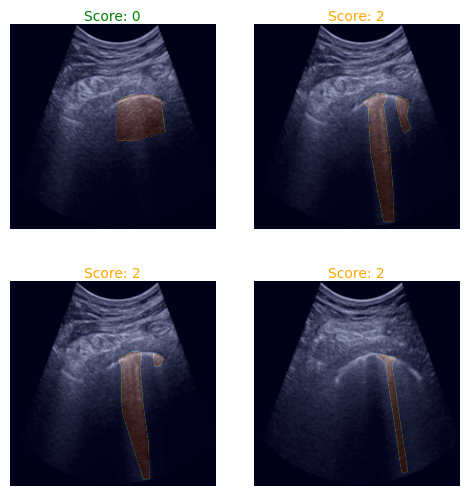

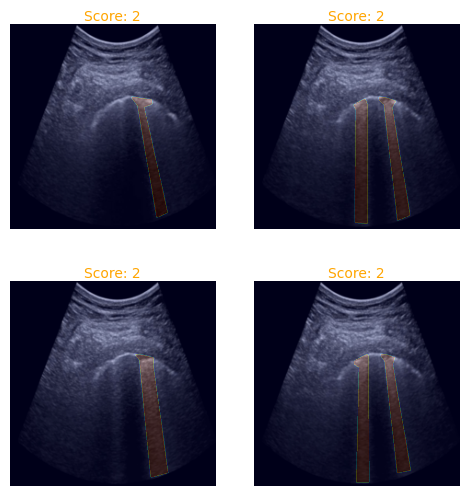



Media: [0.11877374 0.12375458 0.12937458]
Deviazione Standard: [0.16544534 0.1720253  0.18160158]


In [16]:
# test set dataloader (iteration test)
viewlib.dataloader_display_iterator(test_dataloader)